###This tutorial describes some simple steps to do mixture models in rjags

There are two ways:

1. Use latent categorical variables.

2. Use binomial distribution

In [1]:
%load_ext rpy2.ipython

###Create a data set including two normal components

1/sd1^2: 1       1/sd2^2: 4
mean1: 1.02481136493811sd1: 1.06241832974966


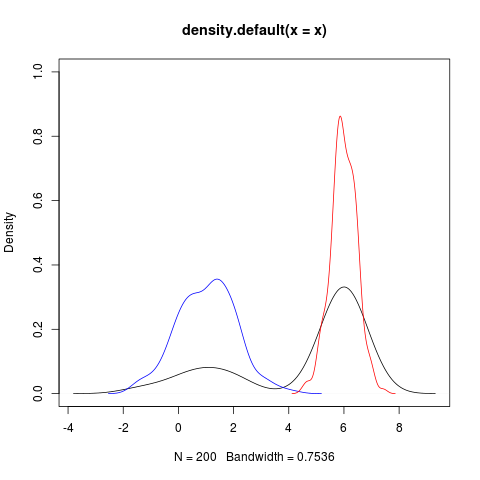

In [20]:
%%R
##Create two normal components
library("rjags")
mu1 <- 1
sd1 <- 1
mu2 <- 6
sd2 <- 0.5

message("1/sd1^2: ", 1/sd1^2, '       1/sd2^2: ', 1/sd2^2)
NN <- 200
x1 <- rnorm(NN, mu1, sd1)

message("mean1: ", mean(x1), "sd1: ", sd(x1))
x2 <- rnorm(NN, mu2, sd2)

pi0 <- 0.3 #Mixing proportion

realPars <- c(mu1, mu2, sd1, sd2, pi0, 1 - pi0)
names(realPars) <- c("mu1", "mu2", "sd1", "sd2", "pi0", "1 - pi0")

xy <- cbind(x1, x2)

x <- apply(xy, 1, function(xChoose) sample(xChoose, 1, prob = c(pi0, 1 - pi0)))

plot(density(x), ylim = c(0, 1))
    
    lines(density(x1), col = 'blue')
    
    lines(density(x2), col = 'red')

###Write the data

In [5]:
%%R
###Write a model in jags code

dataJags <- list(x = x, 
                   NN = NN,
                    alpha0 = c(1, 1) ##Prior information for the latent catogorical variables
                   )

###Use latent categorical variables

In [10]:
%%R
jagsFile = "model{
    for (i in 1:NN){
        x[i] ~ dnorm(mux[i], taux[i])
        mux[i] <- mu0[T[i]]
        taux[i] <- (1/sd0[T[i]])^2 
        T[i] ~ dcat(p1[]) 
    }
    
    p1[1:2] ~ ddirch(alpha0)
    mu0[1] ~ dunif(0, 3)
    mu0[2] ~ dunif(2, 10)
    sd0[1] ~ dunif(0.01, 10) #dnorm(1, 0.1)
    sd0[2] ~ dunif(0.01, 10) #dnorm(0.5, 0.1)I(0, )
}"

In [11]:
%%R
n.chains = 1
n.adapt = 100
        
mixture <- jags.model(textConnection(jagsFile),# inits = inits,
                              data = dataJags, n.chains = n.chains, n.adapt = n.adapt)




Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 1215

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%


In [12]:
%%R
nUpdate = 2000
update(mixture, nUpdate)


n.iter = 5000
thin = 5
xem <- coda.samples(mixture, c('mu0', 'sd0', 'p1'),
                    n.iter = n.iter, thin = thin)

  |**************************************************| 100%
  |**************************************************| 100%


In [13]:
%%R
outMCMC <- xem[[1]]

In [21]:
%%R
message("real parameters: ")
print(realPars)
apply(outMCMC, 2, mean)

real parameters: 
    mu1     mu2     sd1     sd2     pi0 1 - pi0 
    1.0     6.0     1.0     0.5     0.3     0.7 
   mu0[1]    mu0[2]     p1[1]     p1[2]    sd0[1]    sd0[2] 
0.9731993 5.9675061 0.2672650 0.7327350 0.8901307 0.4964075 


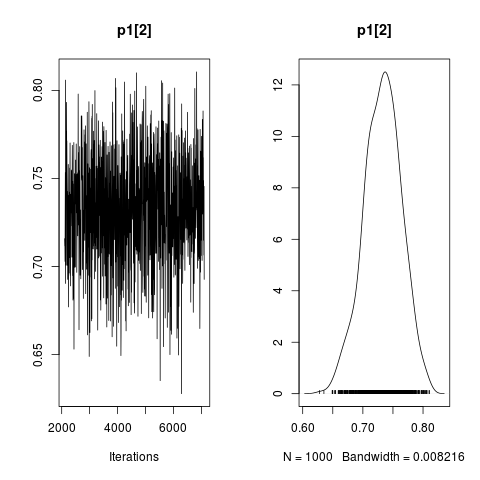

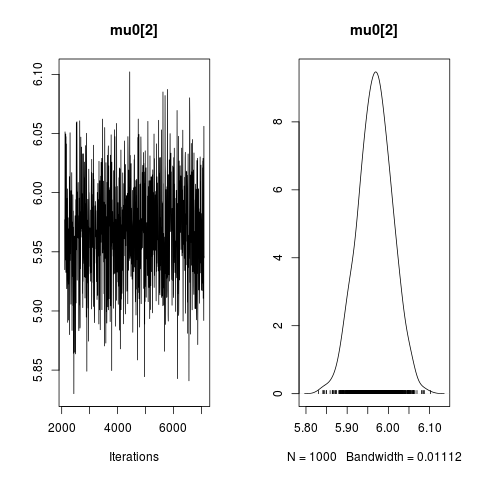

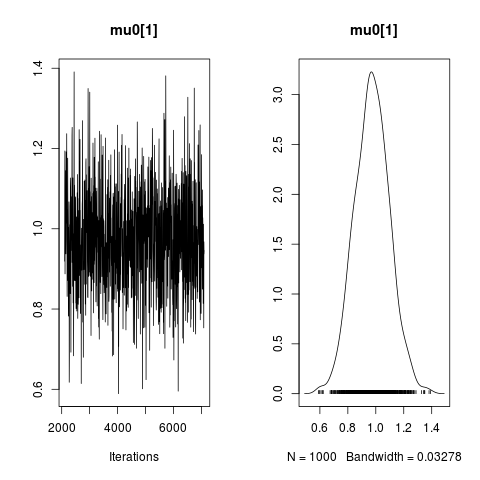

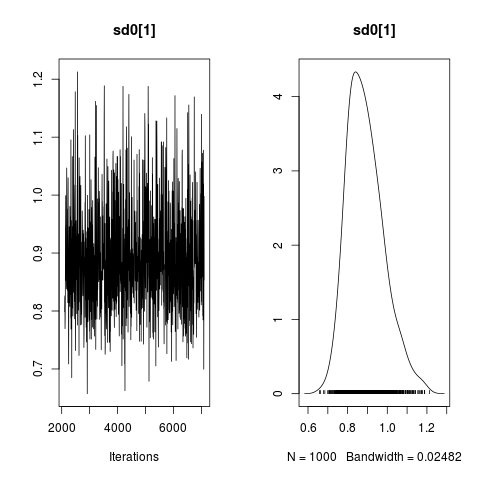

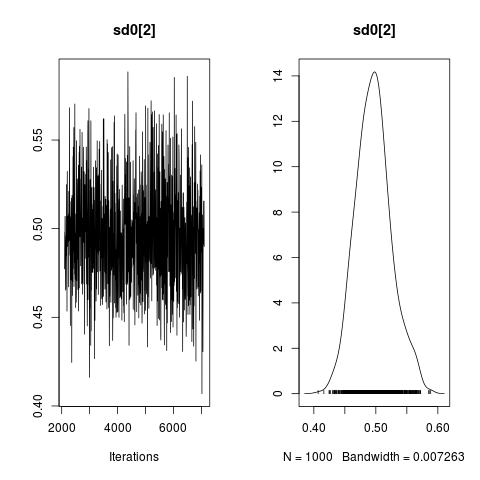

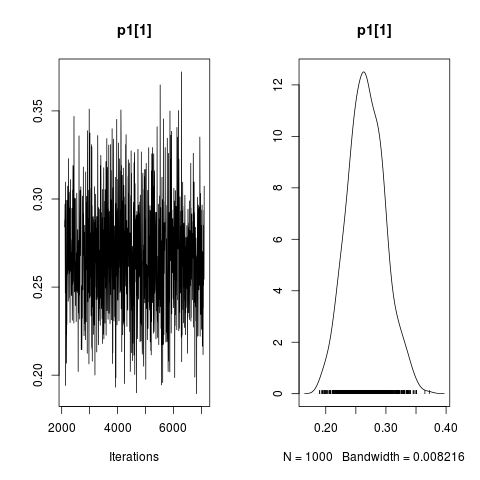

In [22]:
%%R
plot(outMCMC[, 'mu0[1]'], main = 'mu0[1]')
plot(outMCMC[, 'mu0[2]'], main = 'mu0[2]')
plot(outMCMC[, 'sd0[1]'], main = 'sd0[1]')
plot(outMCMC[, 'sd0[2]'], main = 'sd0[2]')
plot(outMCMC[, 'p1[1]'], main = 'p1[1]')
plot(outMCMC[, 'p1[2]'], main = 'p1[2]')

###Use binomial distribution

In [23]:
%%R
jagsFile = "model{
    for (i in 1:NN){
        groupI[i] ~ dbern(p1) ##Choose a group
        inDex[i] <- groupI[i] + 1 ##Move 0-1 to 1-2

        x[i] ~ dnorm(mux[i], taux[i]) ##Samping the data
        mux[i] <- mu0[inDex[i]]
        taux[i] <- (1/sd0[inDex[i]])^2 
        
    }
    
    p1 ~ dunif(0, 1)
    mu0[1] ~ dunif(0, 3)
    mu0[2] ~ dunif(2, 10)
    sd0[1] ~ dnorm(1, 0.1)
    sd0[2] ~ dnorm(0.5, 0.1)I(0, )
}"

In [24]:
%%R
n.chains = 1
n.adapt = 100
        
mixture <- jags.model(textConnection(jagsFile),# inits = inits,
                              data = dataJags, n.chains = n.chains, n.adapt = n.adapt)






Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 1413

Initializing model

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100%


In [25]:
%%R
nUpdate = 2000
update(mixture, nUpdate)

n.iter = 10000
thin = 5
xem <- coda.samples(mixture, c('mu0', 'sd0', 'p1'),
                    n.iter = n.iter, thin = thin)

  |**************************************************| 100%
  |**************************************************| 100%


In [26]:
%%R
outMCMC1 <- xem[[1]]

dim(outMCMC1)


[1] 2000    5


In [27]:
%%R
head(outMCMC1)

Markov Chain Monte Carlo (MCMC) output:
Start = 2105 
End = 2135 
Thinning interval = 5 
        mu0[1]   mu0[2]        p1    sd0[1]    sd0[2]
[1,] 1.0392129 5.908914 0.7388522 0.9445054 0.4648913
[2,] 0.8788825 5.990996 0.6817599 0.7828526 0.5073633
[3,] 0.9042200 6.043645 0.6894579 0.8132035 0.5038954
[4,] 0.8251494 5.917070 0.6776730 0.9563808 0.4929983
[5,] 1.0788081 5.950773 0.7784937 0.9283841 0.4739940
[6,] 0.9268870 5.955755 0.6943383 0.9231079 0.4863631
[7,] 0.9765149 5.850496 0.7089099 0.8795407 0.5296098


In [33]:
%%R
print(realPars)
apply(outMCMC1, 2, mean)

    mu1     mu2     sd1     sd2     pi0 1 - pi0 
    1.0     6.0     1.0     0.5     0.3     0.7 
   mu0[1]    mu0[2]        p1    sd0[1]    sd0[2] 
0.9681289 5.9660660 0.7330685 0.8913831 0.4964198 


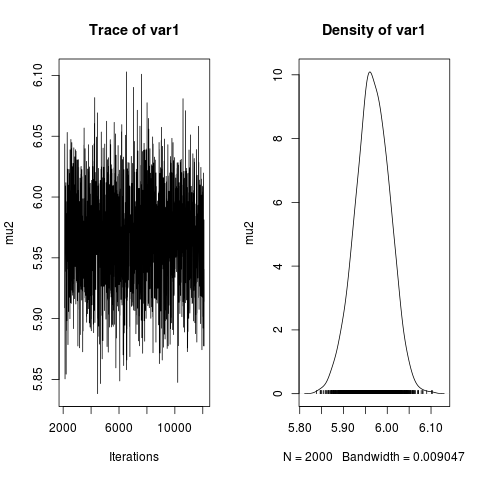

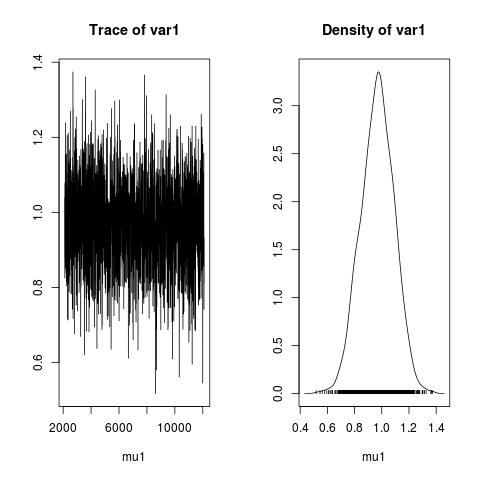

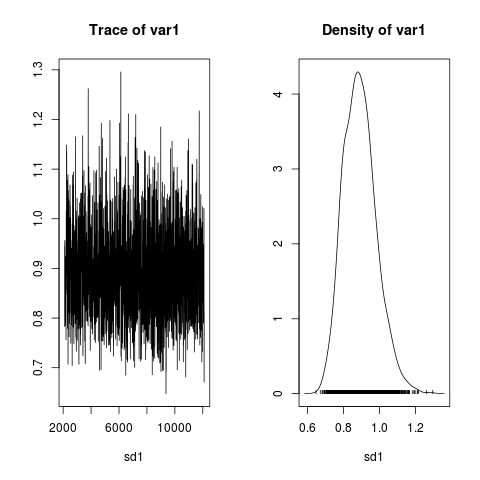

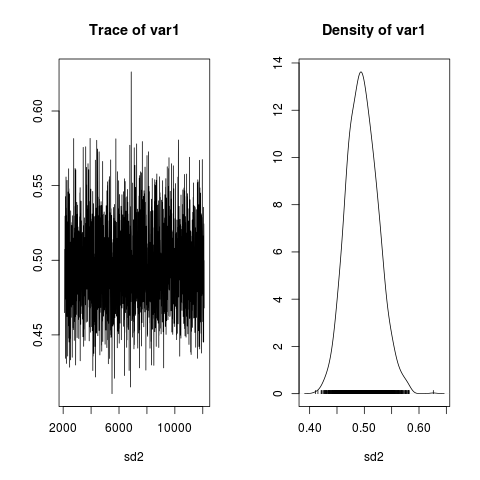

In [29]:
%%R 
plot(outMCMC1[, 'mu0[1]'], xlab = 'mu1')
plot(outMCMC1[, 'mu0[2]'], ylab = 'mu2')
plot(outMCMC1[, 'sd0[1]'], xlab = 'sd1')
plot(outMCMC1[, 'sd0[2]'], xlab = 'sd2')
#plot(outMCMC1[, 'p1'], 'pi')



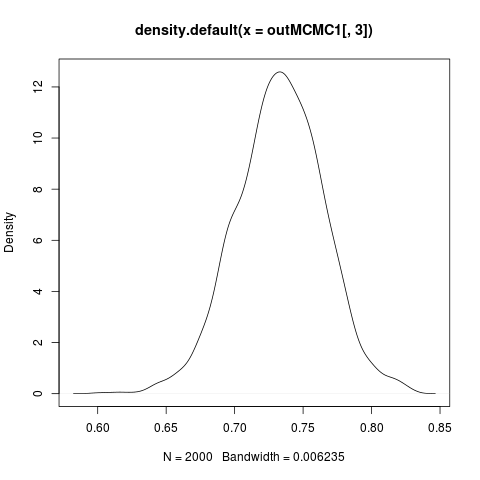

In [30]:
%%R
plot(density(outMCMC1[, 3]))

In [31]:
#!gist -p Tutorial_mixturemodel_with_rjags.ipynb

In [32]:
!gist -u https://gist.github.com/55749763648fe5bf0c8f Tutorial_mixturemodel_with_rjags.ipynb

https://gist.github.com/55749763648fe5bf0c8f
